# We gaan aan de slag met een volgende manier van outlier detection en catgorisering
We gebruiken hier nog steeds grayscale images voor. Dat is nog wat makkelijker.


In [1]:
import os
# File paths for the uploaded images
folder_path = 'image denoise les/undistorted_images'
os.chdir(folder_path)

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import cv2

from PIL import Image
import numpy as np


# Load MNIST dataset
images = []
img_arrays = []
image_filenames = []
for image_name in os.listdir():
    if '.png' in image_name:
        image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
        image = Image.fromarray(image)
        images.append(image)
        # Convert to 1D
        image = np.array((image.resize((28,28), Image.LANCZOS)))
        img_array = np.array(image).flatten() 
        img_arrays.append(img_array)
        image_filenames.append(image_name)





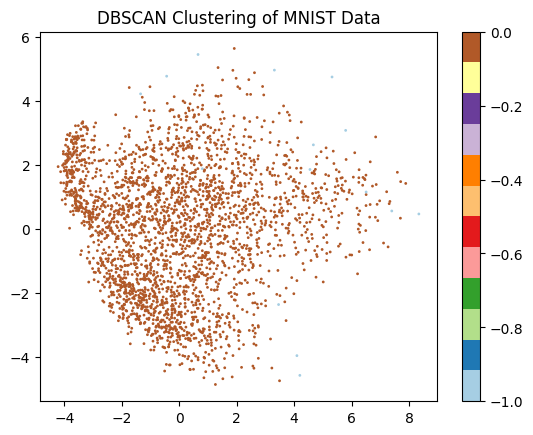

In [3]:


# Convert to a NumPy array
images_array = np.array(img_arrays)
images_array.shape


X = images_array / 255.0  # Normalize the data
# y = mnist.target        # Labels (not used in DBSCAN)

# Dimensionality reduction with PCA
pca = PCA(n_components=3)  # Reduce to 50 dimensions for efficiency
X_pca = pca.fit_transform(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=1, min_samples=3)
clusters = dbscan.fit_predict(X_pca)

# Visualize a subset of the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='Paired', s=1)
plt.colorbar()
plt.title("DBSCAN Clustering of MNIST Data")
plt.show()


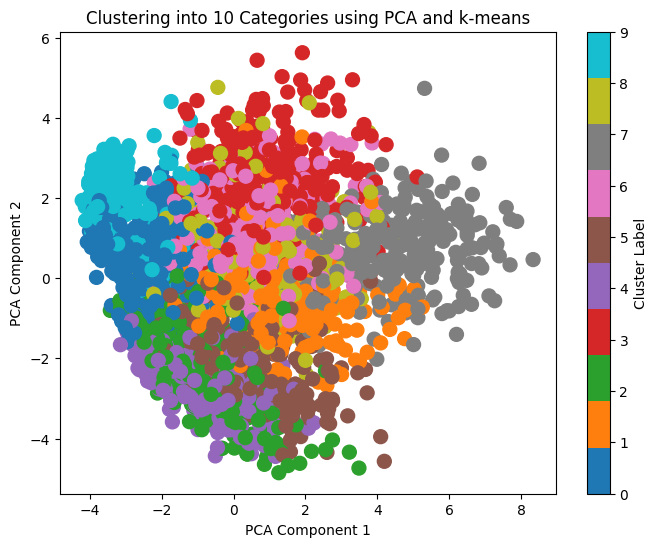

array([1, 7, 2, ..., 2, 5, 7])

In [4]:
from sklearn.cluster import KMeans

# Use PCA to reduce the dimensionality
pca_10 = PCA(n_components=10)  # Reduce to 10 principal components
images_pca_10 = pca_10.fit_transform(images_array)

# Apply k-means clustering with 10 clusters
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(images_pca_10)

# Visualize clusters in 2D (using the first two PCA components)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap="tab10", s=100)
plt.title("Clustering into 10 Categories using PCA and k-means")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster Label")
plt.show()

kmeans_labels


In [5]:
import cv2
from PIL import Image

image_name = 'clean_8.png'
image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
image = Image.fromarray(image)
image

## Nu zelf aan de slag: 
1. Maak een analyse van distorted images om te kijken of deze als outliers worden gezien met de DBscan



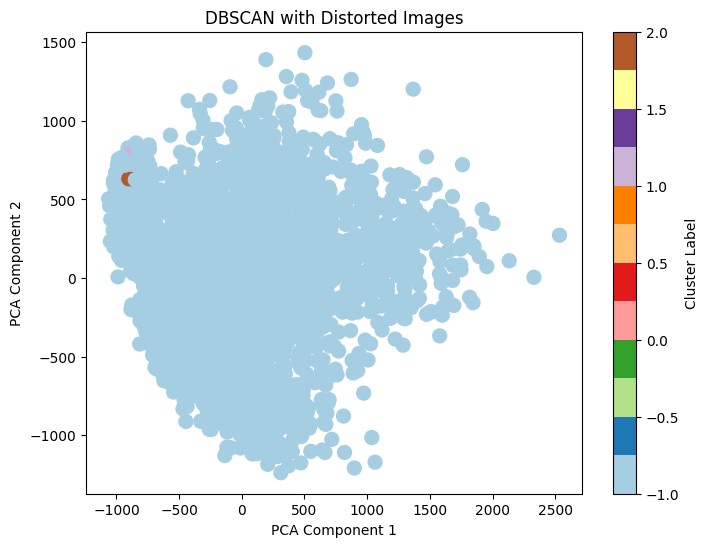

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

In [6]:
import os
# File paths for the uploaded images
# Maak hier aan absoluut pad van mocht dit niet werken. Aangezien we al naar een map zijn geswitcht
folder_path = '../../image denoise les/distorted_images'
os.chdir(folder_path)

distorted_images = []
images = []
for image_name in os.listdir():
    if '.png' in image_name:
        image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
        image = Image.fromarray(image)
        images.append(image)
        # Convert to 1D
        image = np.array((image.resize((28,28), Image.LANCZOS)))
        img_array = np.array(image).flatten() 
        distorted_images.append(img_array)

extended_images = np.vstack([images_array, distorted_images])  # Combine original and distorted

# Apply PCA to the extended dataset
extended_pca = pca.fit_transform(extended_images)

# Re-run DBSCAN on the extended dataset
dbscan_with_distorted = DBSCAN(eps=6, min_samples=2)
clusters_with_distorted = dbscan_with_distorted.fit_predict(extended_pca)

# Visualize the updated clustering with outliers
plt.figure(figsize=(8, 6))
plt.scatter(extended_pca[:, 0], extended_pca[:, 1], c=clusters_with_distorted, cmap="Paired", s=100)
plt.title("DBSCAN with Distorted Images")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster Label")
plt.show()

clusters_with_distorted[-len(distorted_images):]  # Show labels of the distorted images


2. We gaan nu binnen de dataset kijken of we outliers kunnen herkennen (bijvoorbeeld cijfer 1 versus andere cijfers)
- Pak 1 categorie van de PCA (bijvoorbeeld cluster 0) en kijk welk cijfer hierbij past.
- Kijk welke images hierbij horen. (clean1.png, clean 10.png etc.)
- Zorg dat je de DBscan vervolgens traint op alleen deze images
- Pak wat images van andere cijfers en kijk of deze cijfers als outlier worden gezien


In [26]:
np.sum(clusters_with_distorted == 0) # Aantal fotos met cluster 0

2

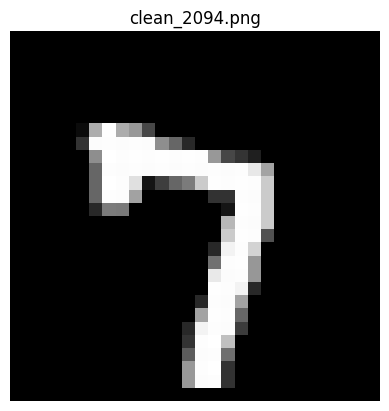

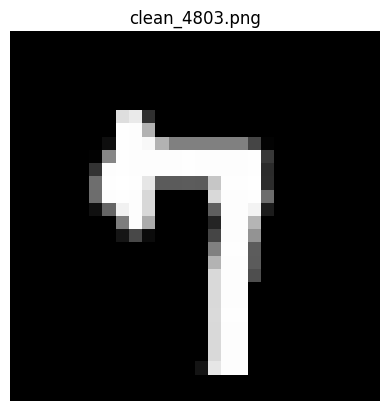

In [27]:
# Hier laat ik alle fotos met cluster 0 zien
cluster_0_indices = np.where(clusters_with_distorted == 0)[0]
originals_in_cluster_0 = cluster_0_indices[cluster_0_indices < len(images_array)]

for i in originals_in_cluster_0:
    img = images_array[i].reshape(28, 28)
    filename = image_filenames[i]

    plt.imshow(img, cmap='gray')
    plt.title(f"{filename}")
    plt.axis('off')
    plt.show()


In [45]:
# DBScan trainen met fotos van cluster 0
cluster_0_images = np.array([images_array[i] for i in originals_in_cluster_0])
pca_cluster_0 = PCA(n_components=2)
cluster_0_pca = pca_cluster_0.fit_transform(cluster_0_images)

dbscan_sub = DBSCAN(eps=3, min_samples=1)
sub_clusters = dbscan_sub.fit_predict(cluster_0_pca)

In [46]:
cluster_1_indices = np.where(clusters_with_distorted == 1)[0]
originals_in_cluster_1 = cluster_1_indices[cluster_1_indices < len(images_array)]
cluster_1_images = np.array([images_array[i] for i in originals_in_cluster_1]) # Dit zijn alle fotos met cluster 1
cluster_1_pca = pca.transform(cluster_1_images)
cluster_1_labels = sub_clusters[len(cluster_0_images):]

outliers = np.where(cluster_1_labels == -1)[0]
print(f"Aantal outliers gedetecteerd door DBSCAN: {outliers}")


Aantal outliers gedetecteerd door DBSCAN: []
